<a href="https://colab.research.google.com/github/JulieMew/DS-Unit-2-Linear-Models/blob/master/LS_DS_212_assignment_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [2]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [4]:
import pandas as pd
print(df.shape)
df.head()

(48817, 34)


bathrooms  bedrooms  ... wheelchair_access common_outdoor_space
0        1.5         3  ...                 0                    0
1        1.0         2  ...                 0                    0
2        1.0         1  ...                 0                    0
3        1.0         1  ...                 0                    0
4        1.0         4  ...                 0                    0

[5 rows x 34 columns]

Split the data

In [5]:
df.describe()

bathrooms      bedrooms  ...  wheelchair_access  common_outdoor_space
count  48817.000000  48817.000000  ...       48817.000000          48817.000000
mean       1.201794      1.537149  ...           0.027224              0.026241
std        0.470711      1.106087  ...           0.162738              0.159852
min        0.000000      0.000000  ...           0.000000              0.000000
25%        1.000000      1.000000  ...           0.000000              0.000000
50%        1.000000      1.000000  ...           0.000000              0.000000
75%        1.000000      2.000000  ...           0.000000              0.000000
max       10.000000      8.000000  ...           1.000000              1.000000

[8 rows x 29 columns]

In [6]:
# Split the data

train = df[df['price'] < 2500]

test = df[df['price'] >= 2500]

In [7]:
train.shape, test.shape #Check the data split.

((12072, 34), (36745, 34))

Train to see how many have laundry and a fitness shelter.

In [8]:
train['dishwasher'].mean() 

0.192428760768721

In [9]:
# Arrange y target vectors
target = 'dishwasher'
y_train = train[target]
y_test = test[target]

In [10]:
y_train

8        0
10       0
11       0
15       0
17       0
        ..
49335    0
49337    1
49340    0
49345    1
49351    0
Name: dishwasher, Length: 12072, dtype: int64

In [11]:
y_test

0        0
1        0
2        1
3        0
4        0
        ..
49346    0
49347    1
49348    0
49349    0
49350    0
Name: dishwasher, Length: 36745, dtype: int64

In [12]:
# Get mean baseline
print('Mean Baseline (using 0 features)')
guess = y_train.mean()

Mean Baseline (using 0 features)


In [13]:
guess

0.192428760768721

In [14]:
# Train Error
from sklearn.metrics import mean_absolute_error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error (dishwasher): {mae:.2f} price')

Train Error (dishwasher): 0.31 price


In [15]:
# Test Error
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error (dishwasher): {mae:.2f} price')

Test Error (dishwasher): 0.49 price


In [16]:
import plotly.express as px

px.scatter( train,
    x='dishwasher',
    y='price',
    text='price',
    title='how dishwashers change price',
    trendline='ols',  # Ordinary Least Squares
)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [17]:
# Train Error
from sklearn.metrics import mean_absolute_error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error (dishwasher): {mae:.2f} fitness_center')

Train Error (dishwasher): 0.31 fitness_center


In [18]:
import plotly.express as px

px.scatter( train,
    x='dishwasher',
    y='price',
    text='price',
    title='how dishwashers change price',
    trendline='ols',  # Ordinary Least Squares
)

Fit a linear regression model with at least two features.

In [19]:
import pandas as pd

# Read NYC Tribeca condo sales data, from first 4 months of 2019.
# Dataset has 90 rows, 9 columns.
df
assert df.shape == (48817, 34)

# Arrange X features matrix & y target vector
features = ['dishwasher', 'price']
target = 'fitness_center'
X = df[features]
y = df[target]

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

ValueError: ignored

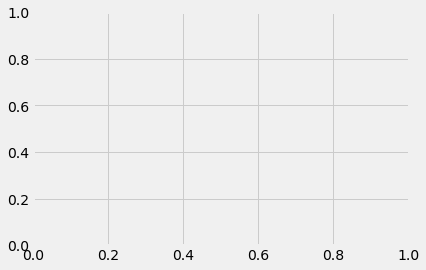

In [21]:
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         LinearRegression(**kwargs))


polynomial_degrees = range(1, 10, 2)
train_r2s = []
test_r2s = []

for degree in polynomial_degrees:
    model = PolynomialRegression(degree)
    display(HTML(f'Polynomial degree={degree}'))
    
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    display(HTML(f'<b style="color: blue">Train R2 {train_r2:.2f}</b>'))
    display(HTML(f'<b style="color: red">Test R2 {test_r2:.2f}</b>'))

    plt.scatter(X_train, y_train, color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, color='red', alpha=0.5)
    plt.xlabel(features)
    plt.ylabel(target)
    
    x_domain = np.linspace(X.min(), X.max())
    curve = model.predict(x_domain)
    plt.plot(x_domain, curve, color='blue')
    plt.show()
    display(HTML('<hr/>'))
    
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)
    
display(HTML('Validation Curve'))
plt.plot(polynomial_degrees, train_r2s, color='blue', label='Train')
plt.plot(polynomial_degrees, test_r2s, color='red', label='Test')
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

Get Coefficients

In [22]:
# TODO: Fit the model
# start with linear regression

model_full = LinearRegression()
model_full.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [23]:
# Calculate training error
y_pred = model_full.predict(X_train)
mean_absolute_error(y_train, y_pred)

0.35140501688184606

In [24]:
# TODO: Apply the model to new data
y_pred = model_full.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.3525718321086649

In [25]:
# get coefficients
model_full.intercept_, model_full.coef_

(0.02266653581038225, array([2.11683912e-01, 4.42641688e-05]))

In [26]:
beta0 = model_full.intercept_
beta1, beta2 = model_full.coef_
print(f'y = {beta0} + {beta1}x1 + {beta2}x2')

y = 0.02266653581038225 + 0.2116839119251755x1 + 4.4264168772168646e-05x2


In [27]:
# This is easier to read
print('Intercept', model_full.intercept_)
coefficients = pd.Series(model_full.coef_, features)
print(coefficients.to_string())

Intercept 0.02266653581038225
dishwasher    0.211684
price         0.000044


In [28]:
X_train.describe()

dishwasher         price
count  36612.000000  36612.000000
mean       0.412679   3573.245384
std        0.492323   1754.356600
min        0.000000   1375.000000
25%        0.000000   2500.000000
50%        0.000000   3150.000000
75%        1.000000   4090.250000
max        1.000000  15500.000000

In [29]:
model = model_full 

In [30]:
model.predict([[0, 0]])

array([0.02266654])

In [31]:
model.predict([[1, 0]])

array([0.23435045])

In [32]:
model.predict([[1, 0]]) - model.predict([[0, 0]])

array([0.21168391])

In [33]:
model.predict([[2, 0]])

array([0.44603436])

In [34]:
model.predict([[2, 0]]) - model.predict([[1, 0]])  # The same diff - linear!

array([0.21168391])

In [35]:
model.predict([[2, 100]])

array([0.45046078])

In [36]:
model.predict([[2, 100]]) - model.predict([[2, 0]])

array([0.00442642])

In [37]:
model.predict([[3, 100]])

array([0.66214469])

In [38]:
model.predict([[3, 100]]) - model.predict([[2, 100]])

array([0.21168391])

In [39]:
model.predict([[3, 200]])

array([0.66657111])

In [40]:
model.predict([[3, 200]]) - model.predict([[3, 100]])

array([0.00442642])

Get mean absolute error

In [41]:
from sklearn.metrics import mean_absolute_error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f' {mae:.2f} percentage points')

 0.36 percentage points


In [42]:
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f' {mae:.2f} percentage points')

 0.36 percentage points


Find RMSE

In [43]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_test, y_pred))


Find $R^2$

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [45]:
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


# Credit for PolynomialRegression: Jake VanderPlas, Python Data Science Handbook, Chapter 5.3
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         LinearRegression(**kwargs))


polynomial_degrees = range(1, 10, 2)
train_r2s = []
test_r2s = []

for degree in polynomial_degrees:
    model = PolynomialRegression(degree)
    display(HTML(f'Polynomial degree={degree}'))
    
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    display(HTML(f'<b style="color: blue">Train R2 {train_r2:.2f}</b>'))
    display(HTML(f'<b style="color: red">Test R2 {test_r2:.2f}</b>'))

    plt.scatter(X_train[:,0], y_train, color='blue', alpha=0.5)
    plt.scatter(X_train[:,0], y_test, color='red', alpha=0.5)
    plt.xlabel(features)
    plt.ylabel(target)
    
    x_domain = np.linspace(X.min(), X.max())
    curve = model.predict(x_domain)
    plt.plot(x_domain, curve, color='blue')
    plt.show()
    display(HTML('<hr/>'))
    
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)
    
display(HTML('Validation Curve'))
plt.plot(polynomial_degrees, train_r2s, color='blue', label='Train')
plt.plot(polynomial_degrees, test_r2s, color='red', label='Test')
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

TypeError: ignored